# FineTuning a Pretrained Model to Distinguish Between Bees and Ants

In this last but one section we will see how to perform the fine tuning of a pretrained model (for real this time).
To do this we will use a simpler dataset, composed by images belonging to just 2 classes, bees and ants.

Q: what does FineTuning actually consists of?

Finetuning means that we downlaod and use a pretrained model as in the previous seciton, but instead of just training the newly added last layer, we should re-train *all* the model's parameters, but using a very low learning rate, in this way we won't change the parameters as much, but we'll permit our model to slowly adapt the parameters to the new task, thus the term FineTuning.

Let's add our usual imports

In [21]:
import torch
from torch.utils import data

import numpy as np
from tqdm import tqdm


from torchvision.datasets.mnist import FashionMNIST
from torchvision.models.resnet import resnet18
from torchvision import transforms, utils, datasets

nn = torch.nn
optim = torch.optim
Variable = torch.autograd.Variable
F = torch.nn.functional

import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

lets create our dataset objects

In [23]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_tr = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

data_dir = '../data/hymenoptera_data'
image_datasets_tr = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform_tr)
image_datasets_val = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform_val)
dataloader_tr = data.DataLoader(image_datasets_tr, shuffle=True, batch_size=4, num_workers=4)
dataloader_val = data.DataLoader(image_datasets_val, shuffle=False, batch_size=4, num_workers=4)

dataset_sizes = {'train': len(image_datasets_tr), 'val': len(image_datasets_val)}

class_names = image_datasets_tr.classes

let's show some sample from the dataset and its label, for this purpose we will create a simple funciton

In [24]:
def imshow(inp, title=None):
    '''imshow for Tensor'''
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.array(std) * inp + np.array(mean)
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=[10,10])
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

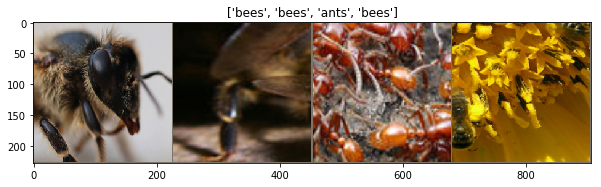

In [25]:
inputs, classes = next(iter(dataloader_tr))
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

Bees, and also Ants.

Let's get our pretrained model, replace the pooling layer and the last fc layer, we will also initialize the newly created fc layer weight data using a normal function having mu=0 and var=0.001

In [26]:
model = resnet18(pretrained=True)
# replace the avgpool (it's a 7x7 pooling expecting Cx7x7 tensors)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
# replace the last layer (it has 1000 out features and we need new weights)
model.fc = nn.Linear(model.fc.in_features, 2)
model.fc.weight.data.normal_(0.0, 0.001)


1.00000e-03 *
 0.5350  1.7353  1.3054  ...  -1.3326 -1.4712  0.2312
 0.0311  0.2751 -0.7756  ...  -2.2236 -0.5811  0.2290
[torch.FloatTensor of size 2x512]

we use a CrossEntropyLoss and SGD algorithm for classification as usual for classification problems. This time we will also make use of a *Learning Rate Scheduler*, which permits us to update the learing rate following a certain rule, in this case we will use the simple StepLR scheduler which accept a **step_size** parameter which corresponds to the amount of steps between each lr update, and a gamma parameter, which will get multiplied with our LR and the results will be our new LR.

in brief the StepLR does:

    every step_size steps:
        LR *= gamma

In [28]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Let's get our training started, as we don't want to wait and want to go drink some beer, we will train the model for just 1 epoch and evaluate the model on the validation dtaset

In [29]:
for epoch in range(1):

    for i, (x, y) in enumerate(dataloader_tr):
        x, y = Variable(x), Variable(y)
        l = loss(model(x), y)

        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        print('Epoch: {}, batch_idx: {}/{}, loss: {}'.format(epoch, i, len(dataloader_tr)-1, l.data.numpy()[0]))

Epoch: 0, batch_idx: 0/60, loss: 0.6996579766273499
Epoch: 0, batch_idx: 1/60, loss: 0.6945157051086426
Epoch: 0, batch_idx: 2/60, loss: 0.6901098489761353
Epoch: 0, batch_idx: 3/60, loss: 0.6946895718574524
Epoch: 0, batch_idx: 4/60, loss: 0.6626502275466919
Epoch: 0, batch_idx: 5/60, loss: 0.7500807046890259
Epoch: 0, batch_idx: 6/60, loss: 0.719589114189148
Epoch: 0, batch_idx: 7/60, loss: 0.6681539416313171
Epoch: 0, batch_idx: 8/60, loss: 0.648646354675293
Epoch: 0, batch_idx: 9/60, loss: 0.6509284973144531
Epoch: 0, batch_idx: 10/60, loss: 0.724002480506897
Epoch: 0, batch_idx: 11/60, loss: 0.7374386787414551
Epoch: 0, batch_idx: 12/60, loss: 0.6299822330474854
Epoch: 0, batch_idx: 13/60, loss: 0.7358139753341675
Epoch: 0, batch_idx: 14/60, loss: 0.6830916404724121
Epoch: 0, batch_idx: 15/60, loss: 0.733338475227356
Epoch: 0, batch_idx: 16/60, loss: 0.6353554725646973
Epoch: 0, batch_idx: 17/60, loss: 0.6218456625938416
Epoch: 0, batch_idx: 18/60, loss: 0.6176905035972595
Epoch: 

Q: Why this time the pretrained model is training faster??

because the dataset is much more small, in terms of number of samples, even if the images are much larger, we roughly have almost a 10% of its number of samples, thus the faster epochs

Let's evaluate the model on the validation dataset as usual

In [30]:
model.eval()
preds = []
ys = []
for x, y in dataloader_val:
    x, y = Variable(x), Variable(y)
    preds.extend(model(x).max(1)[1].data.tolist())
    ys.extend(y.data)

corrects = (np.array(preds) == np.array(ys))
print('Accuracy: {}'.format(corrects.mean()))

Accuracy: 0.7777777777777778


that's actually an awesome result with just one epoch of training, IMHO. But let's count how many images the model classifies wrongly

In [31]:
print('correct predicitons: {}'.format(np.sum(np.array(preds) == np.array(ys))))
print('wrong predicitons: {}'.format(np.sum(np.array(preds) != np.array(ys))))

correct predicitons: 119
wrong predicitons: 34
